# Tutorial: Expression analysis with rnalib, archs4 and genemunge

This notebook contains two parts:

In part 1, we:

* Instatiate the human transcriptome containing protein coding genes with rnalib to extract gene length and exon counts
* Use genemunge to get a list of housekeeping genes, recount2 expression values and Hellinger distance values
* Plot the data


In part 2, we:
* Use rnalib's archs4 interface to get archs4 data (requires download of large data file)


First, we install [genemunge](https://github.com/unlearnai/genemunge) a python package for accessing GTex/recount2 data. NOTE that installation of this package requires hdf5 to be installed. See [here](https://stackoverflow.com/questions/73029883/could-not-find-hdf5-installation-for-pytables-on-m1-mac) for installation via homebrew on MacOS.

In [1]:
#%pip install genemunge

Now we can load all required packages.

In [116]:
import os, pathlib, platform
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import genemunge
import seaborn as sns

# load rnalib
import rnalib as rna
from rnalib import gi, SEP, display_textarea
plt.rcParams["figure.figsize"] = (20,3)

display(f"Running rnalib {rna.__version__} on python {platform.python_version()}")
rna.__RNALIB_TESTDATA__ = "rnalib_testdata/"

'Running rnalib 0.0.2 on python 3.12.1'

#### Test datasets

This notebook as well as rnalib's testing suite use various test resources (genomics data files and indexing structures) that can be created by 
running the rnalib `rnalib_create_testdata` script or by calling the `testdata.create_testdata()` method. There are two seperate resource sets:

* test_resources: small test datasets that are used by rnalib's test suite
* large_test_resources: larger test files that are needed to demonstrate rnalib under realistic conditions. 

Rnalib knows about the test data directory via the package-global __RNALIB_TESTDATA__ variable. This variable can either be set via the "RNALIB_TESTDATA" environment variable or by monkeypatching (rna.__RNALIB_TESTDATA__ = <mydir>) as shown below. Once this is done, test data resources can be accessed via 
`get_resource(<resource_id>)`. Rnalib will recreate these resources only if they are not found in the provided output folder.


In [118]:
if not os.path.isdir(rna.__RNALIB_TESTDATA__):
    os.mkdir(rna.__RNALIB_TESTDATA__)
    display("Creating testdata at {rna.__RNALIB_TESTDATA__ }")
    rna.testdata.create_testdata(rna.__RNALIB_TESTDATA__, 
                                 rna.testdata.large_test_resources)
else:
    display(f"Testdata at {rna.__RNALIB_TESTDATA__}")
    display_textarea('\n'.join(rna.dir_tree(pathlib.Path(rna.__RNALIB_TESTDATA__))))

'Testdata at rnalib_testdata/'

# Part 1: rnalib and genemunge
First, we build subset of human transcriptome containing only canonical, protein coding genes.

In [119]:
t=rna.Transcriptome(
    annotation_gff=rna.get_resource("full_gencode_gff"),
    annotation_flavour='gencode',
    feature_filter=rna.TranscriptFilter().include_tags(['Ensembl_canonical']).include_gene_types(['protein_coding'])
)
t

Building transcriptome (25 chromosomes)
:   0%|          | 0/25 [00:00<?, ?it/s]

Build interval trees:   0%|          | 0/13305 [00:00<?, ?it/s]

Transcriptome with 13305 genes and 47730 tx

Using genemunge, we retrieve a list of housekeeping genes, see see https://www.tau.ac.il/~elieis/HKG/

In [120]:
searcher = genemunge.search.Searcher()
housekeeping_genes = searcher.get_housekeeping_genes()
print(f'Identified {len(housekeeping_genes)} housekeeping genes')

Identified 3620 housekeeping genes


Finally, we can compile tissue-specific expression data for housekeeping and all other genes as
well as some gene-related values (average number of exons per tx, gene length).
We exemplary show data for three tissues ('Blood', 'Bone Marrow', 'Brain'), the expression values are tpm normalized.
Using the transcriptomer model, we can easily access gene length and average number of exons (which naturally correlate) for a downstream analysis.

In [121]:
def get_exp_data(t, genes, housekeeping_genes, tissues=('Blood',)):
    # set up an object to describe genes
    describer = genemunge.describe.Describer('symbol')
    # get major versions of gene ids
    ids = [g.feature_id.split('.')[0] for g in genes]
    # create dataframe
    expression_data = pd.DataFrame(index=ids, columns=['hellinger', 'len', 'n_exon', 'HK']+[f"exp_{tissue}" for tissue in tissues])
    expression_data['len'] = [len(g) for g in genes] # get gene lengths
    expression_data['n_exon'] = [np.mean([len(tx.exon) for tx in g.transcript]) for g in genes] # get mean #exons per gene
    # get the expression levels in healthy tissue (in TPM units)
    for tissue in tissues:
        expression_data[f"exp_{tissue}"] = describer.tissue_stats['median'].reindex(ids)[tissue]
    # get the hellinger distance 
    expression_data['hellinger'] = describer.tissue_stats['hellinger'].reindex(ids)
    # is it a HK gene?
    expression_data['HK']=['yes' if g.feature_id.split('.')[0] in housekeeping_genes else 'no' for g in genes]
    return expression_data

# get expression levels of each gene of interest
tissues=('Blood', 'Bone Marrow', 'Brain')
exp = get_exp_data(t, t.genes, housekeeping_genes, tissues)
exp.describe(include='all')

,hellinger,len,n_exon,HK,exp_Blood,exp_Bone Marrow,exp_Brain
count,13223.000000,1.330500e+04,13305.000000,13305,13223.000000,13223.000000,13223.000000
unique,NaN,NaN,NaN,2,NaN,NaN,NaN
top,NaN,NaN,NaN,no,NaN,NaN,NaN
freq,NaN,NaN,NaN,10952,NaN,NaN,NaN
mean,0.969513,4.879441e+04,6.034697,NaN,46.200134,34.256859,44.508514
std,0.050066,8.511887e+04,4.551019,NaN,2223.567627,458.649475,1174.393799
min,0.339648,1.170000e+02,1.000000,NaN,0.000000,0.000000,0.000000
25%,0.962194,8.376000e+03,3.333333,NaN,0.046394,0.062245,0.270833
50%,0.985865,2.153400e+04,5.000000,NaN,0.893170,2.932727,3.231801
75%,0.998378,5.333600e+04,7.500000,NaN,5.544555,18.579235,10.305368


Now, we plot the tissue-specific expression and the Hellinger distance for housekeeping genes 
vs all others. 

Text(0.5, 0.98, 'Tissue specific expression and Hellinger distance, all vs HK genes')

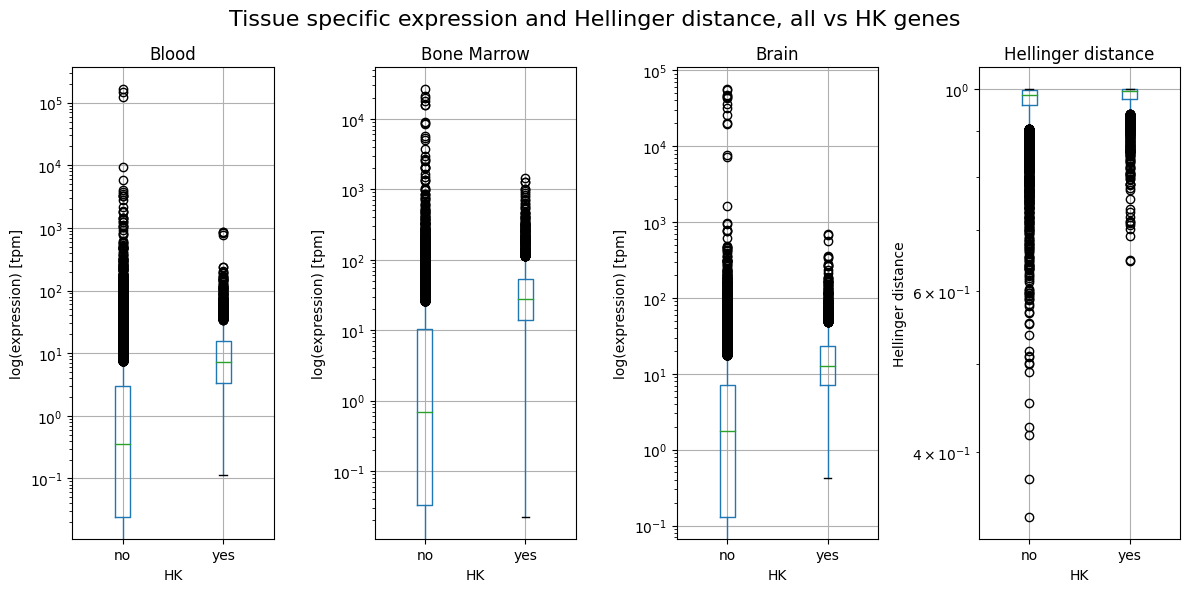

In [122]:
fig, ax = plt.subplots(1, 4, figsize=(12, 6))
for i, tissue in enumerate(tissues):
    exp.boxplot(column=f"exp_{tissue}", by='HK', ax=ax[i])
    ax[i].set_yscale('log')
    ax[i].set_ylabel('log(expression) [tpm]')
    ax[i].set_title(tissue)
exp.boxplot(column='hellinger', by='HK', ax=ax[-1])
ax[-1].set_yscale('log')
ax[-1].set_title('Hellinger distance')
ax[-1].set_ylabel('Hellinger distance')
fig.tight_layout()
fig.suptitle(t='Tissue specific expression and Hellinger distance, all vs HK genes', fontsize=16)

As expected, housekeeping genes have higher expression levels. They also show higher
Hellinger distance values which range between 0 (all tissues have the same expression) and 1 (at least one tissue pair are easily distinguished).

Now, we plot the Hellinger distance vs number of exons and vs gene length. 

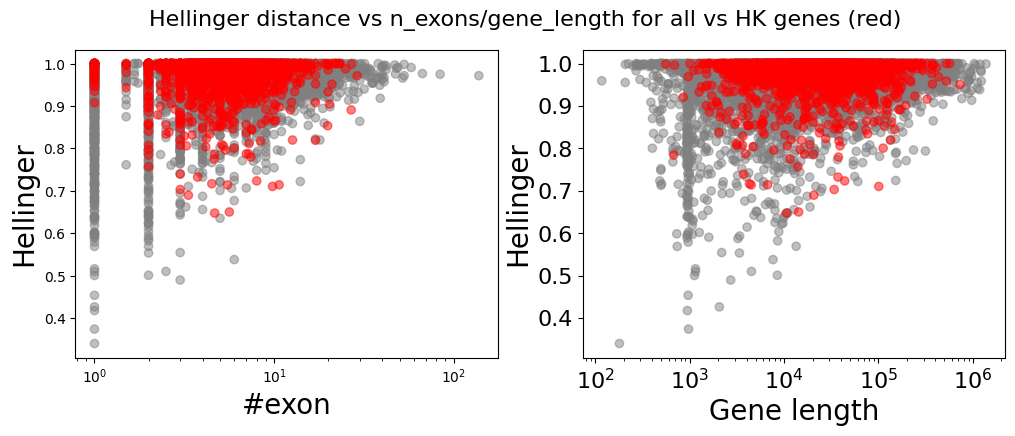

In [123]:
# plot hellinger distance vs gene length
exp=exp.sort_values('HK')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax1.scatter(exp['n_exon'], exp['hellinger'], color=exp['HK'].map({'no':'grey','yes':'red'}),alpha=0.5)
ax1.set_xlabel('#exon', fontsize=20)
ax1.set_xscale('log')
ax1.set_ylabel('Hellinger', fontsize=20)

ax2.scatter(exp['len'], exp['hellinger'], color=exp['HK'].map({'no':'grey','yes':'red'}),alpha=0.5)
ax2.set_xlabel('Gene length', fontsize=20)
ax2.set_xscale('log')
ax2.set_ylabel('Hellinger', fontsize=20)

fig.suptitle(t='Hellinger distance vs n_exons/gene_length for all vs HK genes (red)', fontsize=16);
plt.show()

Longer genes have higher Hellinger distance.

# Part 2: rnalib and archs4

First, we need to download an h5 file from archs4:

In [124]:
archs4_test_resources = {'human_gene_v2.2': {
    'uri': 'https://s3.dev.maayanlab.cloud/archs4/files/human_gene_v2.2.h5',
    'filename': 'bigfiles/human_gene_v2.2.h5',
    'recreate': False}}
rna.testdata.create_testdata(rna.__RNALIB_TESTDATA__, archs4_test_resources)
# access file with rna.get_resource('human_gene_v2.2', conf=archs4_test_resources)

============= Output directory: rnalib_testdata/=========


Creating testdata:   0%|          | 0/1 [00:00<?, ?it/s]

Creating testdataset human_gene_v2.2
Resource already exists, skipping...
========= All done with 0 errors  ==========


Now we can query for datasets...

In [125]:
# query the dataset for samples
with rna.Archs4Dataset(rna.get_resource('human_gene_v2.2', conf=archs4_test_resources)) as a4:
    # a4.describe() # show some sampled data
    # query recent HiSeq datasets with sufficient reads
    df = a4.get_sample_metadata(filter_string = "readsaligned>5000000 & instrument_model.str.contains('HiSeq')") 

  0%|          | 0/468 [00:00<?, ?it/s]

Closing Archs4Dataset at rnalib_testdata//bigfiles/human_gene_v2.2.h5.


Data is in a local dataframe now and we can query it with pandas 

In [126]:
# now, we have a local dataframe and can get familiar with the data
display("Here are the used instruments:", set(df.instrument_model))
display(SEP, "Here are the GEO series with most associated samples:")
df.groupby('series_id').size().reset_index(name='counts').\
    sort_values('counts', ascending=False).head()

'Here are the used instruments:'

{'HiSeq X Ten',
 'Illumina HiSeq 1000',
 'Illumina HiSeq 1500',
 'Illumina HiSeq 2000',
 'Illumina HiSeq 2500',
 'Illumina HiSeq 3000',
 'Illumina HiSeq 4000'}

---

'Here are the GEO series with most associated samples:'

,series_id,counts
7769,GSE193677,2484
281,GSE103147,1594
7170,GSE183635,1502
9014,"GSE47774,GSE47792",1366
6740,GSE177040,1332


In [127]:
# lets get the counts for a random sample of our dataframe
with rna.Archs4Dataset(rna.get_resource('human_gene_v2.2', conf=archs4_test_resources)) as a4:
    df_cnt = a4.get_counts(samples = df.sample(5).index) 
df_cnt

  0%|          | 0/5 [00:00<?, ?it/s]

Closing Archs4Dataset at rnalib_testdata//bigfiles/human_gene_v2.2.h5.


,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,ENSG00000290126,ENSG00000290127,ENSG00000290146,ENSG00000290147,ENSG00000290149,ENSG00000290162,ENSG00000290163,ENSG00000290164,ENSG00000290165,ENSG00000290166
GSM3723955,23,0,1547,1029,421,1181,116,503,560,1280,...,46,5,94,0,3,1,0,1,1,0
GSM3914488,0,21,377,738,299,3577,24,261,888,1749,...,93,0,264,0,0,0,0,0,0,41
GSM5464030,928,4,714,229,79,6,8337,2237,1676,514,...,6,1,186,0,0,0,0,0,0,1
GSM5702306,537,0,1261,185,423,0,18,2784,2040,1136,...,4,1,376,0,0,0,0,0,0,0
GSM6084904,2590,1,749,554,148,366,2585,778,3687,630,...,33,0,105,0,0,0,0,0,0,1


In [128]:
# annotate housekeeping genes in transcriptome
for g in t.genes:
    # get major versions of gene ids
    maj = g.feature_id.split('.')[0]
    t[g]['housekeeping_gene'] = maj in housekeeping_genes
hkg = [g for g in t.genes if g.housekeeping_gene]

In [129]:
# get counts for 1k random samples but for housekeeping genes only. it takes about 4min.
with rna.Archs4Dataset(rna.get_resource('human_gene_v2.2', conf=archs4_test_resources)) as a4:
    df_cnt = a4.get_counts(samples=df.sample(1000).index, gene_symbols=[g.gene_name for g in hkg]) 
df_cnt

  0%|          | 0/1000 [00:00<?, ?it/s]

Closing Archs4Dataset at rnalib_testdata//bigfiles/human_gene_v2.2.h5.


,DPM1,SCYL3,BAD,LAP3,M6PR,ALS2,POLDIP2,HCCS,UPF1,SLC25A5,...,TNRC6A,MRPL23,EIF5A,PEX5,CC2D1A,MCTS1,CTTN,UBL7,CYFIP1,PRKACA
GSM1070774,6346,1497,1407,5249,23770,7618,20394,6396,19525,31647,...,2363,519,28454,1539,1126,1928,16847,1463,2936,1674
GSM1153501,1463,138,411,1540,3317,1063,3296,1049,3367,10677,...,1405,488,15520,321,199,310,1774,691,602,296
GSM1156859,320,85,169,383,923,211,742,169,894,2362,...,214,95,1494,67,131,147,627,173,50,243
GSM1157012,229,59,180,292,715,307,637,119,836,1622,...,204,80,1273,91,141,113,552,135,54,203
GSM1157079,140,58,178,197,480,632,435,91,730,1017,...,236,42,633,87,146,87,416,131,0,248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM6940506,1524,334,1938,2079,5454,1229,4320,906,3551,5494,...,1231,405,9237,371,570,632,7704,606,286,936
GSM6970829,91,116,122,290,242,155,232,65,1028,424,...,89,43,319,40,119,35,409,27,166,168
GSM7047807,773,538,465,3594,4201,2441,5924,290,13682,8181,...,2912,511,12571,1341,1458,319,4601,1143,3126,1508
GSM7196526,446,363,112,523,2766,194,668,286,3141,1669,...,721,81,1510,25,191,146,35,196,348,204


In [130]:
# annotate hkg genes with archs4 counts
for g in hkg:
    t.anno[g]['archs4_cnt'] = df_cnt[g.gene_name] if g.gene_name in df_cnt.columns else None
    t.anno[g]['archs4_mean'] = np.mean(df_cnt[g.gene_name]) if g.gene_name in df_cnt.columns else None

In [132]:
display(t.anno[t['DPM1']]) # show all annotations of gene
display(t['DPM1'].archs4_cnt[df_cnt.index[0]]) # access individual sample
# convert to a pandas dataframe and show HK genes only
df = t.iterator(feature_types='gene').to_dataframe(excluded_columns=('feature_type','gff_feature_type', 'gene_type'))
df[df['housekeeping_gene']]
# alternative: convert to df and add new column with mean expr
#def my_fun(loc, item, fun_col, default_value): 
#    ret=[]
#    for col in fun_col:
#        if col=='mean_exp':
#            if loc.housekeeping_gene and 'archs4_cnt' in item and item['archs4_cnt'] is not None:
#                ret.append(np.mean(item['archs4_cnt']))
#            else:
#                ret.append(default_value)    
#        else:
#            ret.append(loc.get(col, default_value))     
#    return ret
#    
#df = t.iterator(feature_types='gene').to_dataframe(fun=my_fun, included_columns=('mean_exp',))

{'housekeeping_gene': True,
 'archs4_cnt': GSM1070774    6346
 GSM1153501    1463
 GSM1156859     320
 GSM1157012     229
 GSM1157079     140
               ... 
 GSM6940506    1524
 GSM6970829      91
 GSM7047807     773
 GSM7196526     446
 GSM957349     3404
 Name: DPM1, Length: 1000, dtype: uint32,
 'archs4_mean': 1298.763}

6346

,Chromosome,Start,End,Strand,feature_id,housekeeping_gene,archs4_mean,archs4_cnt,source,gene_name
4,chr1,944203,959309,-,ENSG00000188976.11,True,2753.870,GSM1070774 19544 GSM1153501 5121 GSM115...,HAVANA,NOC2L
15,chr1,1216909,1232067,-,ENSG00000078808.19,True,3241.351,GSM1070774 12491 GSM1153501 1903 GSM115...,HAVANA,SDF4
17,chr1,1253909,1273864,-,ENSG00000160087.21,True,1143.938,GSM1070774 6453 GSM1153501 1445 GSM11568...,HAVANA,UBE2J2
19,chr1,1308597,1311677,+,ENSG00000169972.12,True,331.765,GSM1070774 1573 GSM1153501 740 GSM11568...,HAVANA,PUSL1
23,chr1,1373730,1375207,-,ENSG00000175756.14,True,1532.936,GSM1070774 6242 GSM1153501 3019 GSM11568...,HAVANA,AURKAIP1
...,...,...,...,...,...,...,...,...,...,...
13247,chrX,154483717,154486615,-,ENSG00000102178.13,True,1143.518,GSM1070774 5072 GSM1153501 1037 GSM11568...,HAVANA,UBL4A
13249,chrX,154506159,154516242,-,ENSG00000071889.17,True,776.126,GSM1070774 4667 GSM1153501 335 GSM11568...,HAVANA,FAM3A
13259,chrX,155025980,155060304,+,ENSG00000165775.18,True,1343.542,GSM1070774 1695 GSM1153501 1422 GSM11568...,HAVANA,FUNDC2
13261,chrX,155197007,155239841,+,ENSG00000155959.12,True,1378.874,GSM1070774 3784 GSM1153501 1700 GSM11568...,HAVANA,VBP1


Let's plot some of the data

/var/folders/kp/q945z6v94jl3myn35wzsl5n00000gp/T/ipykernel_50558/741414651.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)


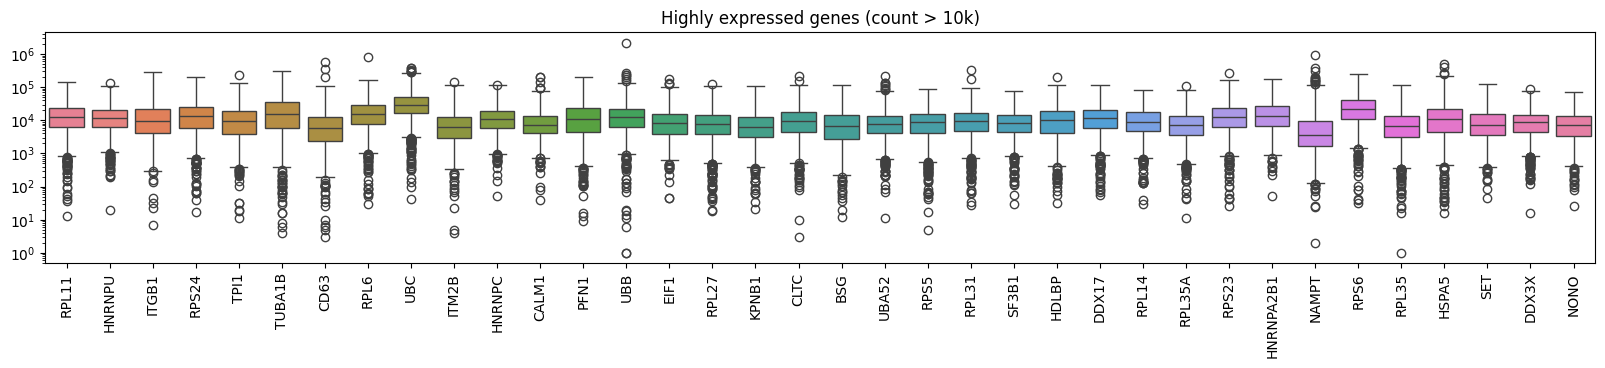

In [133]:
# create a gene: [exp_val1, ..., exp_valn] dict of HK genes with mean exp > 10k
high_mean_hkg = {g.gene_name: g.archs4_cnt for g in hkg if g.get('archs4_mean',None) is not None and g.get('archs4_mean',None) >10000}
# plot
ax = sns.boxplot(data=high_mean_hkg, log_scale=True)
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
_ = ax.set_title('Highly expressed genes (count > 10k)')